In [1]:
from tqdm.notebook import tqdm

from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import repeat

import matplotlib.pyplot as plt

import numpy as np

from scipy.fft import fft, fftfreq, ifft
from scipy.optimize import curve_fit

from timescales.sim import sim_branching
from timescales.fit import convert_knee_val
from timescales.decompose import sim_asine, decompose_ar, iter_estimate_freq
from timescales.decompose.decompose import _fit_decompose_ar

from neurodsp.sim import sim_oscillation, sim_bursty_oscillation
from neurodsp.utils.norm import normalize_sig
from neurodsp.spectral import compute_spectrum

from spectrum import pburg, arburg
from statsmodels.tsa.api import ARIMA

### Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.


#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = e^{j \phi_{i}} e^{j 2\pi f_{i} n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

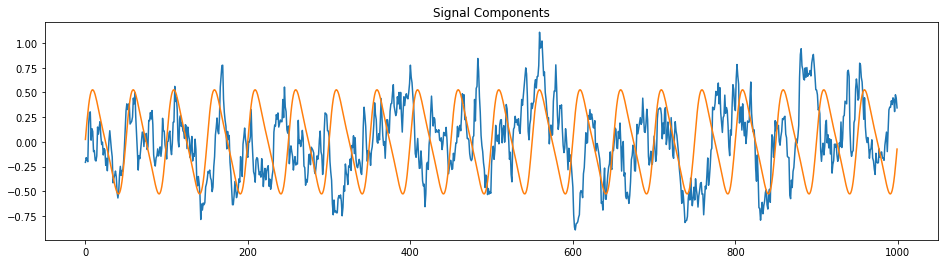

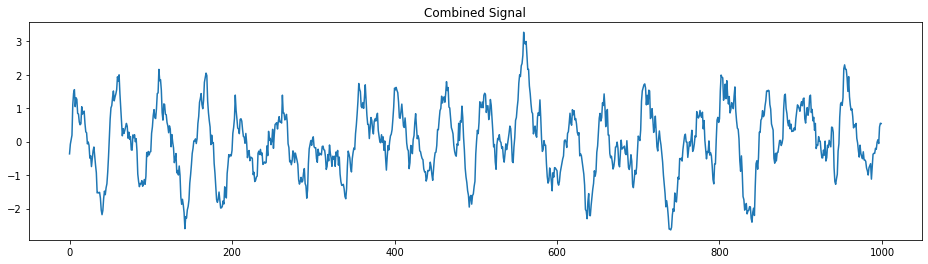

In [2]:
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
xs = np.arange(fs)

lfp = sim_branching(n_seconds, fs, tau, 100)

#osc = sim_oscillation(n_seconds, fs, 20)
#osc = sim_oscillation(n_seconds, fs, 20, 'asine', rdsym=.8)
osc = sim_asine(xs, fs, 20, .25, -.49, 1)

osc_var = .5
lfp = normalize_sig(lfp, 0, (1-osc_var)) 
osc = normalize_sig(osc, 0, (osc_var)) 

sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);


In [3]:
# Fit
ys = sig
xs = np.arange(len(ys))

s_order = 1
p_order = 2

guess, bounds = iter_estimate_freq(sig, fs, s_order, 20, 10)

osc_params = decompose_ar(ys, fs, s_order, p_order, bounds=bounds, guess=guess, maxfev=1000)

osc_fit, ar_fit, params = _fit_decompose_ar(xs, ys, fs, s_order, p_order, *osc_params, return_params=True)

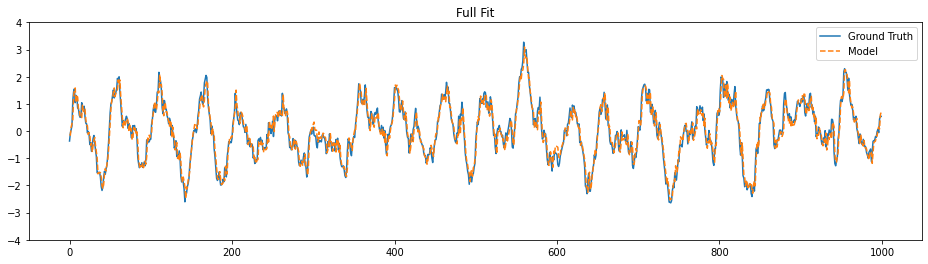

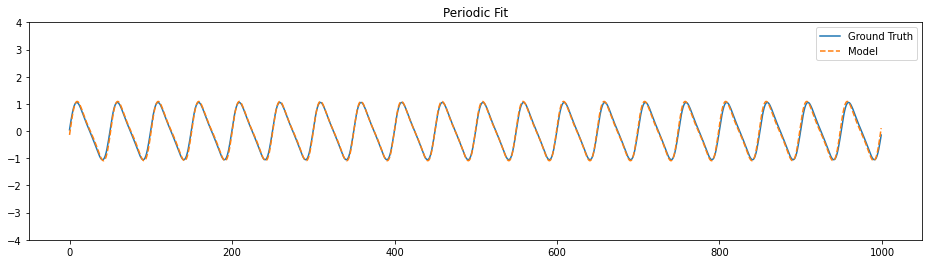

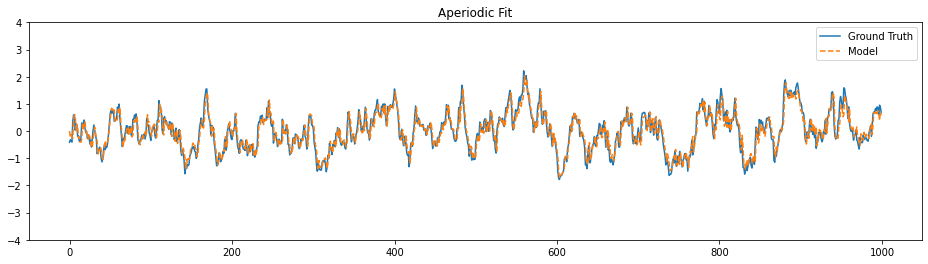

In [4]:
# Plot Results
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(ys, label='Ground Truth')
plt.plot(osc_fit + ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(osc_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();
